## DataPreprocessing

input,target,target_weight,meta=next(batch_iter)，在训练的时候会用到input,target,target_weight,meta信息，所以以下主要讨论它们分别是怎么生成的  
1. 图像处理
2. target生成
3. meta生成

### 1 图像处理
*以下情况是针对于模型训练的时候，测试的时候略有不同，有些步骤在测试时会没有。*  
 首先读取图像，读取图像后，可能会对图像进行翻转，这是随机的。接下来对图像进行仿射变化，之前处理的图像都是numpy的形式，为了输入模型，需要把图片的numpy形式转换为tensor。
 - 图像翻转
 - 仿射变换
 - 将numpy转换成tensor

#### 1.1 图像翻转

In [1]:
from skimage import io,draw
import os,json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

json中value的关键字为dict_keys(['joints_vis', 'joints', 'image', 'scale', 'center']),其中joints_vis为一维的list,长度为16,因为MPII中一共标注了16个关节点，对应为(0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)。  
- jonts_vis:一维list,长度为16,value为0，1.0表示这个关节不可见，1表示可见.
- joints:二维list,16行2列,表示16个关节点的坐标
- image:图像名称
- scale:
- center:

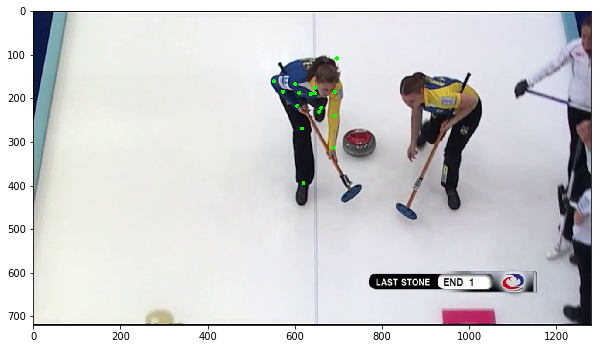

In [2]:
#可视化关节点
img_dir='/input0/MPII/images'

with open('/input0/MPII/annot/train.json') as fr:
    train_j=json.load(fr)

img_name=train_j[0]['image']
img=io.imread('%s/%s'%(img_dir,img_name))
joints=train_j[0]['joints']
for each_point in joints:
    
    rr,cc=draw.circle(each_point[1],each_point[0],5)

    draw.set_color(img,[rr,cc],[0,255,0])
plt.figure(figsize=(10,10))
plt.imshow(img)

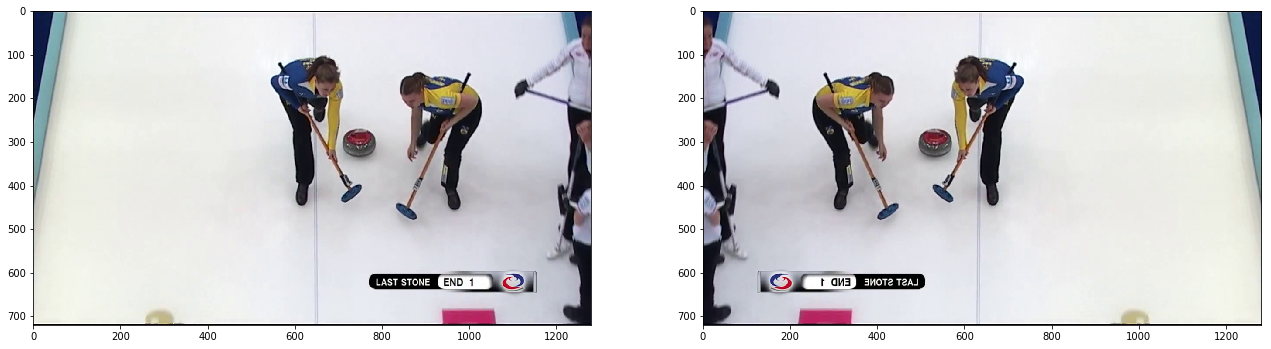

In [3]:
#进行图像翻转
img_name=train_j[0]['image']
img=io.imread('%s/%s'%(img_dir,img_name))
img_flip=img[:,::-1,:]
plt.figure(figsize=(22,22))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_flip)

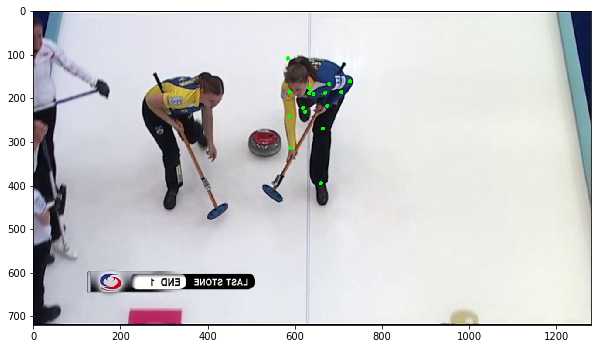

In [4]:
#图像翻转后对应的坐标也应发生改变
joints=np.array(joints)
flip_joints=joints
flip_joints[:,0]=img.shape[1]-joints[:,0]
for each_point in flip_joints:
    
    rr,cc=draw.circle(each_point[1],each_point[0],5)

    draw.set_color(img_flip,[rr,cc],[0,255,0])
plt.figure(figsize=(10,10))
plt.imshow(img_flip)

#### 1.2 仿射变换

What is an Affine Transformation?

    It is any transformation that can be expressed in the form of a matrix multiplication (linear transformation) followed by a vector addition (translation).

    From the above, We can use an Affine Transformation to express:
        Rotations (linear transformation)
        Translations (vector addition)
        Scale operations (linear transformation)

    you can see that, in essence, an Affine Transformation represents a relation between two images.


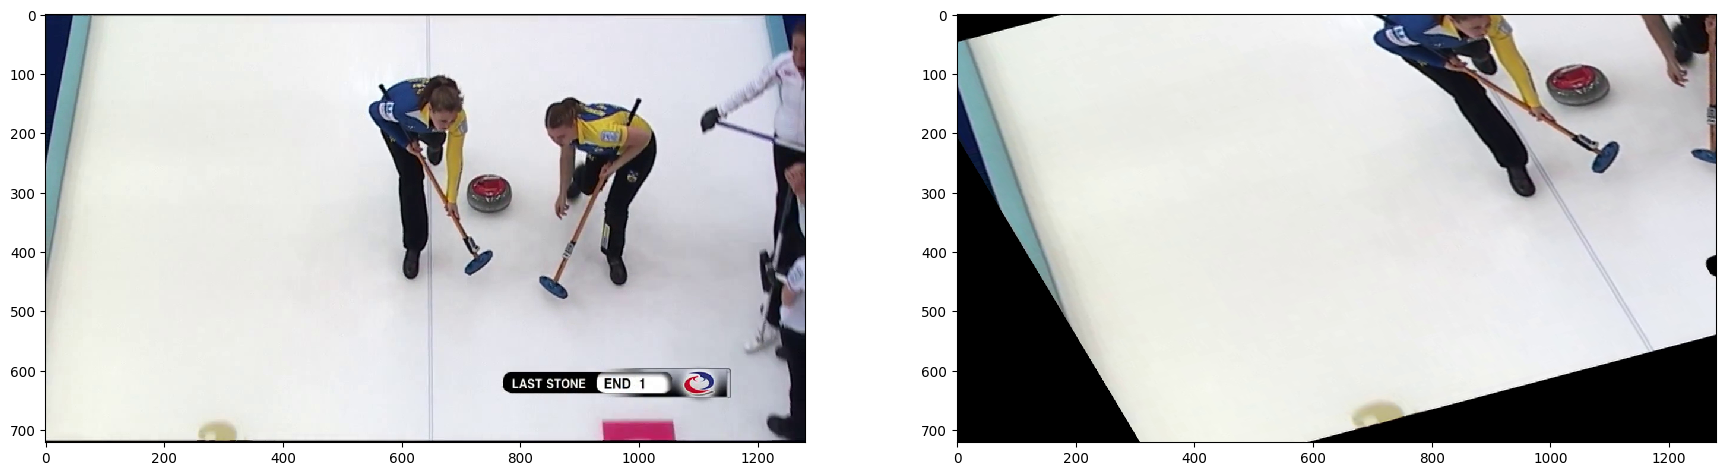

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt4

img=io.imread('%s/%s'%(img_dir,img_name))
rows, cols, ch = img.shape

#pts1中为任意选择的三个点，pts2中为pts1中三个点变换后对应的点
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])

M = cv2.getAffineTransform(pts1, pts2)
dst = cv2.warpAffine(img, M, (cols, rows))


plt.figure(figsize=(22, 22), dpi=98)
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(dst)

plt.show()

In [6]:
#后面后常用到
joints=train_j[0]['joints']
joints_vis=np.array(train_j[0]['joints_vis'])
joints=np.array(joints)

joints_3d=np.zeros((16,3))
joints_vis_3d=np.zeros((16,3))

joints_3d[:,:2]=np.array(joints)-1
joints_vis_3d[:,0]=np.array(joints_vis)
joints_vis_3d[:,1]=np.array(joints_vis)


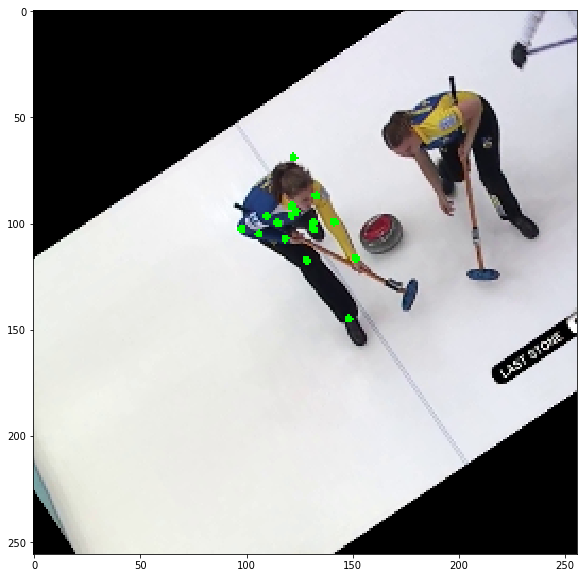

In [7]:
from lib.utils.transforms import *
import copy

#mpii.py中MPIIDataset的方法_get_db()对c,s的定义
c=np.array(train_j[0]['center'])-1
s=np.array([train_j[0]['scale'],train_j[0]['scale']])
if c[0] != -1:
    c[1] = c[1] + 15 * s[1]
    s = s * 1.25
c=c-1

#JointsDataset.py中方法__getitem__()对c,s进行了稍微的变化
sf=0.25
rf=30
s= s * np.clip(np.random.randn()*sf + 1, 1 - sf, 1 + sf)
r=np.clip(np.random.randn()*rf, -rf*2, rf*2) \
                if random.random() <= 0.6 else 0

img_size=[256,256]

#仿射变化,trans返回(2,3)的矩阵
trans=get_affine_transform(c,s,r,img_size)
# print(trans.shape)
img=io.imread('%s/%s'%(img_dir,img_name))
#input为仿射变化后的图像，大小也变成了模型输入的大小(256,256)
input = cv2.warpAffine(
            img,
            trans,
            (int(256), int(256)),
            flags=cv2.INTER_LINEAR)

input_2 = cv2.warpAffine(
            img,
            trans,
            (int(256), int(256)),
            flags=cv2.INTER_LINEAR)

#仿射变化后，关节点的坐标也发生了变化
aff_joints_3d=copy.deepcopy(joints_3d) #若不采用深拷贝，直接附值的话aff_joints_3d的改变会影响joints_3d的改变
for i in range(16):
    if joints_vis_3d[i, 0] > 0.0:
        aff_joints_3d[i, 0:2] = affine_transform(joints_3d[i, 0:2], trans)
        

for each_point in aff_joints_3d:
    
    rr,cc=draw.circle(each_point[1],each_point[0],2)

    draw.set_color(input,[rr,cc],[0,255,0])
    
plt.figure(figsize=(10,10)) 
plt.imshow(input)

#### 1.3 数据预处理，包括将numpy转换为tensor和归一化

In [14]:
import torchvision,torch
print(type(input),input.shape)
normalize = torchvision.transforms.Normalize(
          
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
input_t=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])(input)
input_t=torch.unsqueeze(input_t,0)
print(type(input_t),input_t.size())
#可以把这个作为模型的输入

<class 'numpy.ndarray'> (256, 256, 3)
<class 'torch.Tensor'> torch.Size([1, 3, 256, 256])


### 2.生成target
*在损失函数中，并没有直接使用关节点的坐标，而是使用的heatmap图，也就是target*  
target相当于groud truth,在计算MSE的时候会用到，模型的输出也是(batch_size,num_joints,64,64),其含义同target。  

(16, 64, 64)


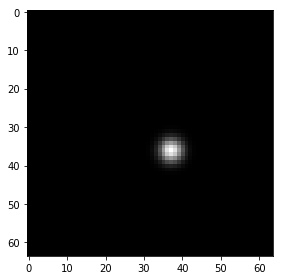

In [9]:
#lib/dataset/JointsDataset.py  

from skimage import io
def generate_target(joints, joints_vis):
    '''
    input:
        joints: narray, [num_joints, 3],此处的joints应该为经过仿射变化后的图像的关节点的坐标值，因为最终输入模型的是经过仿射变化后的图像，坐标也应该对应
        joints_vis: narray,[num_joints, 3]，仿射变化并不影响joins_vis的值
    return: 
        target：narray,[16,64,64]，target最初是0矩阵，会在关节点的位置产生高斯分布。
        eg:在(256,256,3)的图像中对应第0个关节点的坐标是[115.8,169.1],先把它转换为64*64图像中对应的坐标，[115.8,169.1]/256*64=[28.95,42.275],加上0.5后取整为[29,42].
        g是生成的13*13大小的满足高斯分布的数组，其中心点g[6,6]=1,为最大值。
        target[29-6:29+6,42-6:42+6]位置的值由0变为g的值。
        (所有64*64的heatmap图中，g的值都是一样的，只是位置不同)
        
        target_weight(1: visible, 0: invisible):narray,[16,1],值与joints_vis同
        
    '''
    
    #设置参数，这些都是在config中预设置好的，为了便于理解，这儿单独将函数抽出来观察target是如何生成的
    target_type='gaussian'
    num_joints=16
    heatmap_size=[64,64]
    sigma=2
    image_size=[256,256]
    image_size,heatmap_size=np.array(image_size),np.array(heatmap_size)
    use_different_joints_weight=False
    
    
    target_weight = np.ones((16, 1), dtype=np.float32)
    target_weight[:, 0] = joints_vis[:, 0]

#     assert self.target_type == 'gaussian', \
#         'Only support gaussian map now!'

    if target_type == 'gaussian':
        target = np.zeros((num_joints,
                           heatmap_size[1],
                           heatmap_size[0]),
                          dtype=np.float32)

        tmp_size = sigma * 3

        for joint_id in range(num_joints):
            feat_stride = image_size / heatmap_size
            #mu_x,mu_y即将256*256中的关节点的坐标放到64*64的图中的坐标
            mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
            mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
            # Check that any part of the gaussian is in-bounds
            ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
            br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
            if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] \
                    or br[0] < 0 or br[1] < 0:
                # If not, just return the image as is
                target_weight[joint_id] = 0
                continue

            # # Generate gaussian
            size = 2 * tmp_size + 1
            x = np.arange(0, size, 1, np.float32)
            y = x[:, np.newaxis]
            x0 = y0 = size // 2
            # The gaussian is not normalized, we want the center value to equal 1
            #可以看出来对于所有循环中g的值都是一样的
            g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2)         / (2 * sigma ** 2))  #g.shape:(13,13)
#             print(g)
            # Usable gaussian range
            #g_x=(0,13),g_y=(0,13)
            g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
            g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
            # Image range
            #Image range即关节点周围的13*13的像素
            img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
            img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

            v = target_weight[joint_id]
            if v > 0.5:
                #索引里面范围是(13,13),即img_y[1]-img_y[0]==13,img_x[1]-img_x[0]==13,
#                 也即改变target中13*13个元素的值为高斯分布的值
                target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                    g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
         
        
    if use_different_joints_weight:
        target_weight = np.multiply(target_weight, joints_weight)

    return target, target_weight



target,target_weight=generate_target(aff_joints_3d,joints_vis_3d)
print(target.shape)
io.imshow(target[0,:,:])

生成heatmap+原图

In [10]:
import torchvision.transforms as transforms
import torch
from scipy import misc
'''
input:
    input_2:经过仿射变换后的图像,需要经过transform的转换
    heatmap:numpy,(16,64,64),需要转换成tensor
    
'''

heatmap_size=64
#数据处理,包括对图像进行归一化，把图像从numpy转换为tensor
normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
input_t=transforms.Compose([transforms.ToTensor(),normalize])(input_2)
#将归一化的图像还原为原图
min=input_t.min()
max=input_t.max()
input_t=input_t.add_(-min).div_(max-min+1e-5)

img=input_t.mul(255).clamp(0,255).byte().permute(1,2,0).cpu().numpy()

#将target转换成tensor
heatmap=torch.from_numpy(target)
heatmap=heatmap.mul(255).clamp(0,255).byte().cpu().numpy()

# print(heatmap.shape)
num_joints=16
resized_img=cv2.resize(img,(64,64))

grid_image=np.zeros((64,(16+1)*64,3))
grid_image[0:64,0:64,:]=resized_img

for j in range(num_joints):
    cv2.circle(resized_img,(int(joints[j][0]),int(joints[j][1])),1,[0,0,255],1)
    colored_heatmap = cv2.applyColorMap(heatmap[j,:,:], cv2.COLORMAP_JET)
    masked_image = colored_heatmap*0.7 + resized_img*0.3   
    cv2.circle(masked_image,
                       (int(joints[j][0]), int(joints[j][1])),
                       1, [0, 0, 255], 1)
    width_begin=(j+1)*heatmap_size
    width_end=(j+2)*heatmap_size
    grid_image[0:heatmap_size,width_begin:width_end,:]=masked_image
    

print(grid_image.shape)
cv2.imwrite('heatmap.jpg',grid_image)

(64, 1088, 3)


True